In [2]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import time
import sys
import os

import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime, date

# preamble for jupyter notebook and django
import django
import platform

if platform.node() == "srv-mcc-apsis":
    sys.path.append("/home/muef/tmv/BasicBrowser/")
    #sys.path.append('/home/leey/tmv/BasicBrowser/')
    dtm_path = "/home/galm/software/dtm/dtm/main"
else:
    # local paths
    sys.path.append('/media/Data/MCC/tmv/BasicBrowser/')
    dtm_path = "/home/finn/dtm/dtm/main"

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

# import from appended path
import parliament.models as pm
import scoping.models as sm
from parliament.tasks import do_search, run_tm, combine_searches
import cities.models as cmodels
from django.contrib.auth.models import User
from tmv_app.models import * 
from utils.tm_mgmt import update_topic_scores
from django.db.models import Q, Count, Func, F, Sum, Avg, Value as V
from django.db.models.functions import TruncDate, TruncMonth, TruncYear

In [3]:
# function definitions for correlations

user1 =  User.objects.get(username='muef')

def dfdt(qs):
    ## Make a queryset of doctopics into a pandas
    ## df in the format we want to used
    df = pd.DataFrame(qs)
    if 'topic_id' not in df.columns:
        df = df.rename(columns={
            'tc': 'score',
            'topic__topicdtopic__dynamictopic_id': 'topic_id'
        })
    return df

def correlate_topics(df, doc_id):

    df = df.pivot(
        index=doc_id,
        columns='topic_id',
        values='score'
    ).fillna(0)

    corr = df.corr()
    #values = corr.values
    #cols = corr.columns

    return corr
    # end def correlate_topics

# function for calculating topic correlation
# with slicing by party

def corr_topics(run_id, party_name=None, period=None):
    print("Calculating topic correlation for party {} and period {} in run {}".format(party_name, period, run_id))
    stat = RunStats.objects.get(pk=run_id)
    s_id = stat.psearch.id

    if stat.psearch is not None:
        doc_id = 'ut_id'
        tars = DynamicTopicTimePeriodScores
    else:
        doc_id = 'doc_id'
        tars = DynamicTopicARScores

    if stat.method=="DT":
        periods = stat.periods.all()
        dts = DocTopic.objects.filter(
            topic__topicdtopic__dynamictopic__run_id=run_id,
            topic__topicdtopic__score__gt=0.05,
            score__gt=0.05
        )
        
        if party_name:
            dts = dts.filter(ut__speaker__party__name=party_name)
        if period is not None:
            dts = dts.filter(ut__document__parlperiod__n=period)
        
        dts = dts.values(
            doc_id,'topic__topicdtopic__dynamictopic_id'
        ).annotate(
            tc=Sum(F('score') * F('topic__topicdtopic__score'),
        )).values(
            doc_id,
            'topic__topicdtopic__dynamictopic_id',
            'tc'
        )

        df = dfdt(list(dts))

        obj = DynamicTopicCorr

    else:
        dts = DocTopic.objects.filter(run_id=run_id)
        if party_name:
            dts = dts.filter(ut__speaker__party__name=party_name)
        if period is not None:
            dts = dts.filter(ut__document__parlperiod__n=period)
            
        dts = dts.values(doc_id,'topic_id','score')
        
        df = dfdt(list(dts))

        tars = TopicARScores
        obj = TopicCorr

        if stat.query:
            periods = scoping.models.AR.objects.all()
        else:
            periods = stat.periods.all()

    #df = df.pivot(index='topic_id',columns='doc_id',values='scaled_score')

    # pseudo code for docwise:
    # There are 96 billion combinations, so need to limit
    # For each doc, compare with docs that have a topic_score > 0 of the
    # Largest topic in the doc.
    #obj.objects.filter(run_id=run_id,ar=ar['n']).delete()
    corr = correlate_topics(df, doc_id)
    
    K = RunStats.objects.get(pk=run_id).K
    uts = pm.Utterance.objects.filter(search_matches__id=s_id)
    if party_name:
        uts = uts.filter(speaker__party__name=party_name)
    
    print("filtered docs * K: {}".format(uts.count() * K))
    print("df shape: {}".format(df.shape))
    
    return corr

In [4]:
# function definitions for creating and plotting graphs 

import networkx as nx

def get_graph(corr, threshold):
    adjacency_matrix = corr.ge(threshold).values - np.identity(corr.shape[0])
    G = nx.from_numpy_array(adjacency_matrix)
    print(nx.info(G))
    
    topic_ids = list(corr.index)

    labels = {}
    top_words = {}
    ids = {}
    scores = {}
    for i, topic_id in enumerate(topic_ids):
        topic = Topic.objects.get(id=topic_id)
        labels[i] = topic.title
        ids[i] = topic.id
        #top_words[i] = ", ".join(topic.top_words)
        scores[i] = topic.score
        
    nx.set_node_attributes(G, labels, name="label")
    nx.set_node_attributes(G, ids, name="id")
    nx.set_node_attributes(G, scores, name="totalscores")

    nx.set_node_attributes(G, top_words, name="topwords")
    
    weights = {}
    for i in range(len(topic_ids)):
        for j in range(len(topic_ids)):
            weights[(i, j)] = float(corr.values[i][j])
    
    nx.set_edge_attributes(G, weights, "weight")

    return G


def show_graph(G):
    
    fig = plt.figure()
    
    #pos=nx.circular_layout(G)
    pos=nx.spring_layout(G)

    #nx.draw_networkx_edges(G, pos)
    #nx.draw_networkx_nodes(G, pos, )
    colors = list(nx.get_node_attributes(G, "totalscore").values())
    
    nx.draw(G, pos, node_color=colors, node_cmap=plt.cm.Blues,
            width=2, edge_cmap=plt.cm.Blues, with_labels=False)

    nx.draw_networkx_labels(G,pos,nx.get_node_attributes(G,"label"),font_size=8)
    
    

    plt.show()
    
def corr_hist(corr, threshold_pct):
    vals = (corr.values - np.identity(corr.shape[0])).flatten()
    threshold = np.percentile(vals, threshold_pct)
    print("threshold: {}".format(threshold))
    plt.hist(vals, bins=50)
    return threshold

In [13]:
def show_matrix(m, topic_list=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(m)
    if topic_list:
        plt.xticks(np.arange(len(topic_list)), topic_list, rotation='vertical', fontsize=8)
        plt.yticks(np.arange(len(topic_list)), topic_list, fontsize=8)
    cbar = fig.colorbar(cax)
    plt.show()

In [6]:
run_id = 1749

# get topic scores per period
dts = DocTopic.objects.filter(run_id=run_id)
topic_period_scores = dts.values('topic__title','ut__document__parlperiod__n').annotate(score = Sum('score'))

df = pd.DataFrame.from_dict(topic_period_scores)
df.columns = ['score', 'topic', 'parlperiod']
df_period_scores = df.pivot(index='parlperiod', columns='topic', values='score')
df_period_scores

# get topic scores per party
topic_period_scores = dts.values('topic__title','ut__speaker__party__name').annotate(score = Sum('score'))

df = pd.DataFrame.from_dict(topic_period_scores)
df.columns = ['score', 'topic', 'party']
df_party_scores = df.pivot(index='party', columns='topic', values='score')
df_party_scores

topic,EU,R&D,biofuels,budget,budget 2,climate policy,climate protection,conservation,development,east germany,...,mixed 2,mixed 3,nuclear,power grid,procedural 1,procedural 2,procedural 3,rail transport,regional policy,targets
party,,,,,,,,,,,,,,,,,,,,,
NaN,289.924234,44.626790,43.220351,856.267148,684.352341,103.897763,581.334571,455.093402,147.838799,792.812744,...,164.493413,345.058176,1082.078546,0.450000,818.678509,4.366245,227.829811,35.685565,453.863285,691.656524
afd,106.514625,60.871105,0.750000,489.462299,20.571809,98.522916,1589.110159,412.096912,243.830508,439.877753,...,305.795107,1681.184280,243.434579,92.044221,701.385388,44.927869,1926.904943,73.924531,450.775644,3746.366009
cducsu,14205.991057,3045.557118,948.366474,18128.499733,10918.326526,10951.348300,4079.822164,10152.016250,7764.311195,7244.179478,...,18122.582250,31669.060474,17292.578429,2478.143266,23836.160448,8549.092121,7494.191528,1487.989565,4205.447372,23194.380496
fdp,3963.264744,1819.897675,402.201674,6962.044602,3910.689350,6306.038329,1421.989376,3922.049938,2222.926742,3258.628856,...,6283.268475,25825.004533,5418.481420,903.324137,4189.200876,9141.367308,2859.547069,628.023748,457.232922,6227.967351
fraktionslos,11.836523,0.010000,0.010000,0.010000,0.010000,74.398964,0.010000,8.472059,0.010000,7.977584,...,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
gruene,4952.539171,1187.568825,614.762387,15993.381727,3210.424528,23543.387873,17065.488532,6033.876805,6262.043944,3134.707387,...,6028.867310,11754.939561,5078.771361,1694.432640,9436.538640,5422.094043,21640.179489,1595.646786,2069.381052,10373.294717
linke,1401.609884,324.580685,368.485713,5752.746247,1227.566661,9603.656361,6377.828905,3521.866457,3958.656874,3258.888579,...,1904.945846,5491.790268,2384.115511,2601.467406,1704.236006,2122.337096,5590.349405,618.777399,2706.248107,5556.644482
parteilos,8.071253,254.933640,0.060000,174.348507,21.806781,10.062005,0.060000,47.998998,117.507062,7.517559,...,54.513444,300.398721,12.742389,0.060000,109.470939,8.043828,108.302519,3.137090,9.405799,4.601317
pds,30.968692,6.351364,3.772103,713.379292,213.642375,78.400145,11.303142,171.533128,38.693554,753.328821,...,96.205666,551.630563,457.382864,27.697875,88.283011,21.609138,282.432041,43.924680,28.495701,158.852934


In [5]:
save_dir = './topic_correlations/{}'.format(run_id)
if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

Calculating topic correlation for party spd and period None in run 1749
filtered docs * K: 22140
df shape: (22140, 3)


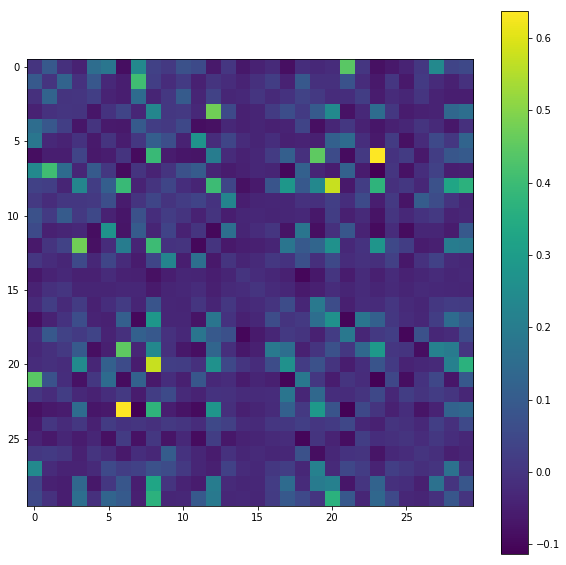

Name: 
Type: Graph
Number of nodes: 30
Number of edges: 179
Average degree:  11.9333


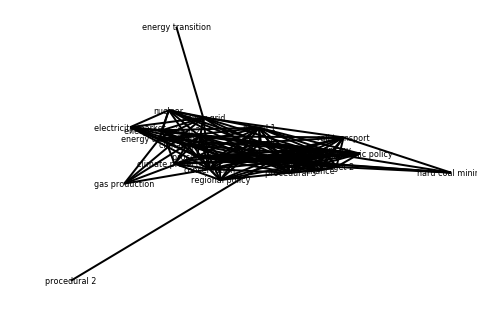

In [18]:
# generate graphs for parties

new_labels = False
threshold0 = True

for party_name in ['spd']: #[None, 'spd', 'cducsu', 'fdp', 'linke', 'gruene', 'afd']:

    corr = corr_topics(run_id, party_name=party_name)
    
    show_matrix(corr.replace(to_replace=1, value=0))

    if threshold0:
        G = get_graph(corr, 0)
    else:
        threshold = corr_hist(corr, 90)
        G = get_graph(corr, threshold)
    
    if party_name:
        scores = {}
        topic_labels = nx.get_node_attributes(G, 'label')
        for node_id, topic_label in topic_labels.items():
            scores[node_id] = float(df_party_scores[topic_label][party_name])
            
        nx.set_node_attributes(G, scores, 'totalscores') 

    if new_labels:
        node_labels = {}
        topic_ids = nx.get_node_attributes(G, 'id')
        for node_id, topic_id in topic_ids.items():
            node_labels[node_id] = labels[topic_id]
        
        nx.set_node_attributes(G, node_labels, 'label') 
        
    
    #filename = os.path.join(save_dir, 'topic_correlations_run{}_party_{}.graphml'.format(run_id, party_name))
    #nx.write_graphml(G, filename)
    #print("saved graph in {}".format(filename))
    
    show_graph(G)

Calculating topic correlation for party None and period 13 in run 1749
filtered docs * K: 105060
df shape: (11580, 3)
Name: 
Type: Graph
Number of nodes: 30
Number of edges: 187
Average degree:  12.4667
saved graph in ./topic_correlations/1749/topic_correlations_run1749_period_13.graphml


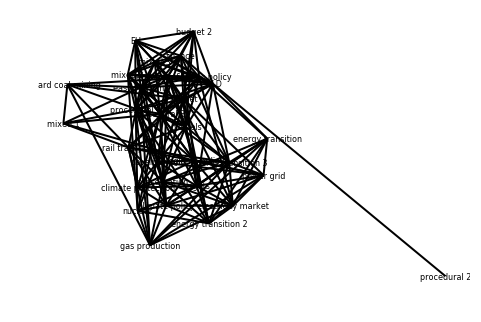

Calculating topic correlation for party None and period 14 in run 1749
filtered docs * K: 105060
df shape: (13980, 3)
Name: 
Type: Graph
Number of nodes: 30
Number of edges: 209
Average degree:  13.9333
saved graph in ./topic_correlations/1749/topic_correlations_run1749_period_14.graphml


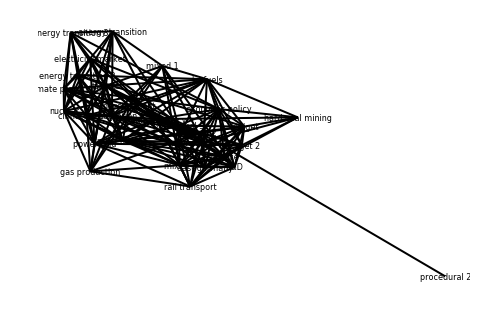

Calculating topic correlation for party None and period 15 in run 1749
filtered docs * K: 105060
df shape: (11130, 3)
Name: 
Type: Graph
Number of nodes: 30
Number of edges: 197
Average degree:  13.1333
saved graph in ./topic_correlations/1749/topic_correlations_run1749_period_15.graphml


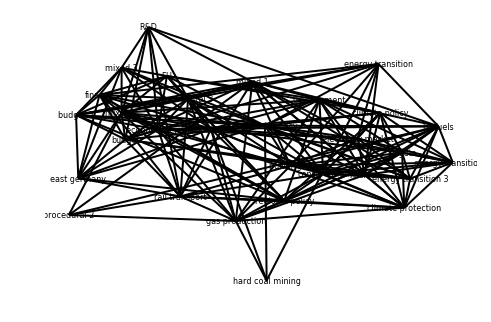

Calculating topic correlation for party None and period 16 in run 1749
filtered docs * K: 105060
df shape: (19230, 3)
Name: 
Type: Graph
Number of nodes: 30
Number of edges: 187
Average degree:  12.4667
saved graph in ./topic_correlations/1749/topic_correlations_run1749_period_16.graphml


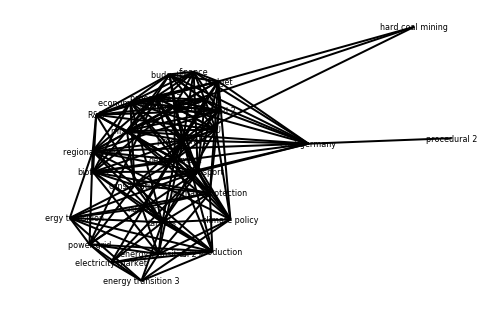

Calculating topic correlation for party None and period 17 in run 1749
filtered docs * K: 105060
df shape: (16530, 3)
Name: 
Type: Graph
Number of nodes: 30
Number of edges: 177
Average degree:  11.8000
saved graph in ./topic_correlations/1749/topic_correlations_run1749_period_17.graphml


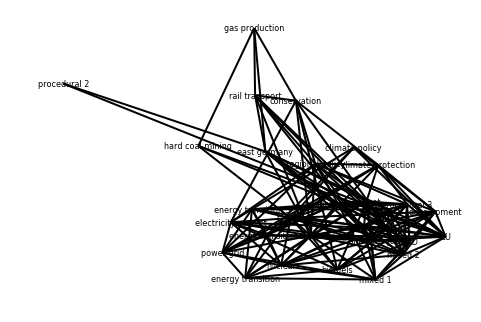

Calculating topic correlation for party None and period 18 in run 1749
filtered docs * K: 105060
df shape: (17280, 3)
Name: 
Type: Graph
Number of nodes: 30
Number of edges: 195
Average degree:  13.0000
saved graph in ./topic_correlations/1749/topic_correlations_run1749_period_18.graphml


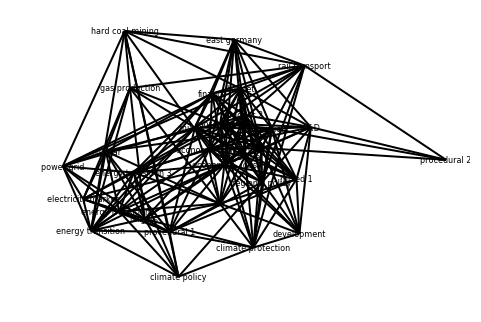

Calculating topic correlation for party None and period 19 in run 1749
filtered docs * K: 105060
df shape: (15330, 3)
Name: 
Type: Graph
Number of nodes: 30
Number of edges: 118
Average degree:   7.8667
saved graph in ./topic_correlations/1749/topic_correlations_run1749_period_19.graphml


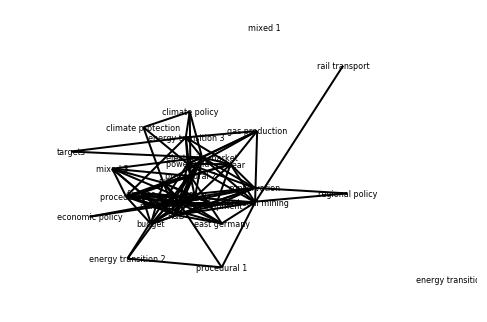

In [9]:
# generate graphs for parliamentary periods

for period in [13, 14, 15, 16, 17, 18, 19]:

    corr = corr_topics(run_id, period=period)

    if threshold0:
        G = get_graph(corr, 0)
    else:
        threshold = corr_hist(corr, 90)
        G = get_graph(corr, threshold)
    
    topic_ids = nx.get_node_attributes(G, 'id')
    
    scores = {}
    topic_labels = nx.get_node_attributes(G, 'label')
    for node_id, topic_label in topic_labels.items():
        scores[node_id] = float(df_period_scores[topic_label][period])
        
    nx.set_node_attributes(G, scores, 'totalscores')
    
    if new_labels:
        node_labels = {}
        for node_id, topic_id in topic_ids.items():
            node_labels[node_id] = labels[topic_id]
            
        nx.set_node_attributes(G, node_labels, 'label')
    
    filename = os.path.join(save_dir, 'topic_correlations_run{}_period_{}.graphml'.format(run_id, period))
    nx.write_graphml(G, filename)
    print("saved graph in {}".format(filename))
    
    show_graph(G)

# compress folder to easily download it

In [12]:
%%bash
zip -r topic_correlations/1749.zip topic_correlations/1749/

  adding: topic_correlations/1749/ (stored 0%)
  adding: topic_correlations/1749/topic_correlations_run1749_period_17.graphml (deflated 80%)
  adding: topic_correlations/1749/topic_correlations_run1749_party_fdp.graphml (deflated 80%)
  adding: topic_correlations/1749/topic_correlations_run1749_party_cducsu.graphml (deflated 80%)
  adding: topic_correlations/1749/topic_correlations_run1749_period_16.graphml (deflated 80%)
  adding: topic_correlations/1749/topic_correlations_run1749_period_14.graphml (deflated 80%)
  adding: topic_correlations/1749/topic_correlations_run1749_period_13.graphml (deflated 80%)
  adding: topic_correlations/1749/topic_correlations_run1749_party_None.graphml (deflated 80%)
  adding: topic_correlations/1749/topic_correlations_run1749_party_afd.graphml (deflated 80%)
  adding: topic_correlations/1749/topic_correlations_run1749_party_linke.graphml (deflated 80%)
  adding: topic_correlations/1749/topic_correlations_run1749_party_gruene.graphml (deflated 80%)
  ad

In [26]:
nx.get_node_attributes(G, 'label')

{0: 'targets',
 1: 'energy transition 3',
 2: 'power grid',
 3: 'procedural 3',
 4: 'electricity market',
 5: 'development',
 6: 'budget 2',
 7: 'energy transition 2',
 8: 'economy & jobs',
 9: 'conservation',
 10: 'nuclear',
 11: 'climate protection',
 12: 'mixed 3',
 13: 'regional policy',
 14: 'procedural 2',
 15: 'energy transition',
 16: 'economic policy',
 17: 'east germany',
 18: 'procedural 1',
 19: 'budget',
 20: 'mixed 2',
 21: 'climate policy',
 22: 'rail transport',
 23: 'finance',
 24: 'mixed 1',
 25: 'hard coal mining',
 26: 'gas production',
 27: 'biofuels',
 28: 'R&D',
 29: 'EU'}

Calculating topic correlation for spd in run 1739
filtered docs * K: 29520
df shape: (29520, 3)
threshold: 0.06944110454687229
Name: 
Type: Graph
Number of nodes: 40
Number of edges: 80
Average degree:   4.0000


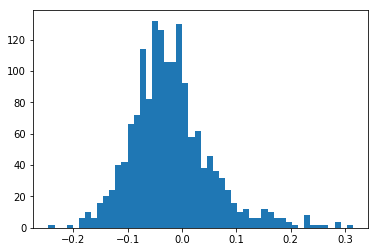

In [30]:
party_name = 'spd'
corr = party_corr_topics(1739, party_name)

threshold = corr_hist(corr, 90)

G = get_graph(corr, threshold)

#nx.write_graphml(G, 'topic_correlations_{}.graphml'.format(party_name))
#show_graph(G)

In [ ]:
# remove duplicates while preserving order

from collections import OrderedDict

terms = Term.objects.filter(topicterm__topic=topic).order_by('-topicterm__score').values('title', 'topicterm__score')[:stat.periods.all().count() * no_top_words]

odict = OrderedDict({})

for t in terms:
    if not t['title'] in odict.keys():
        odict[t['title']] = t['topicterm__score']

#list(OrderedDict.fromkeys(items))
print(odict)
print(len(odict))
